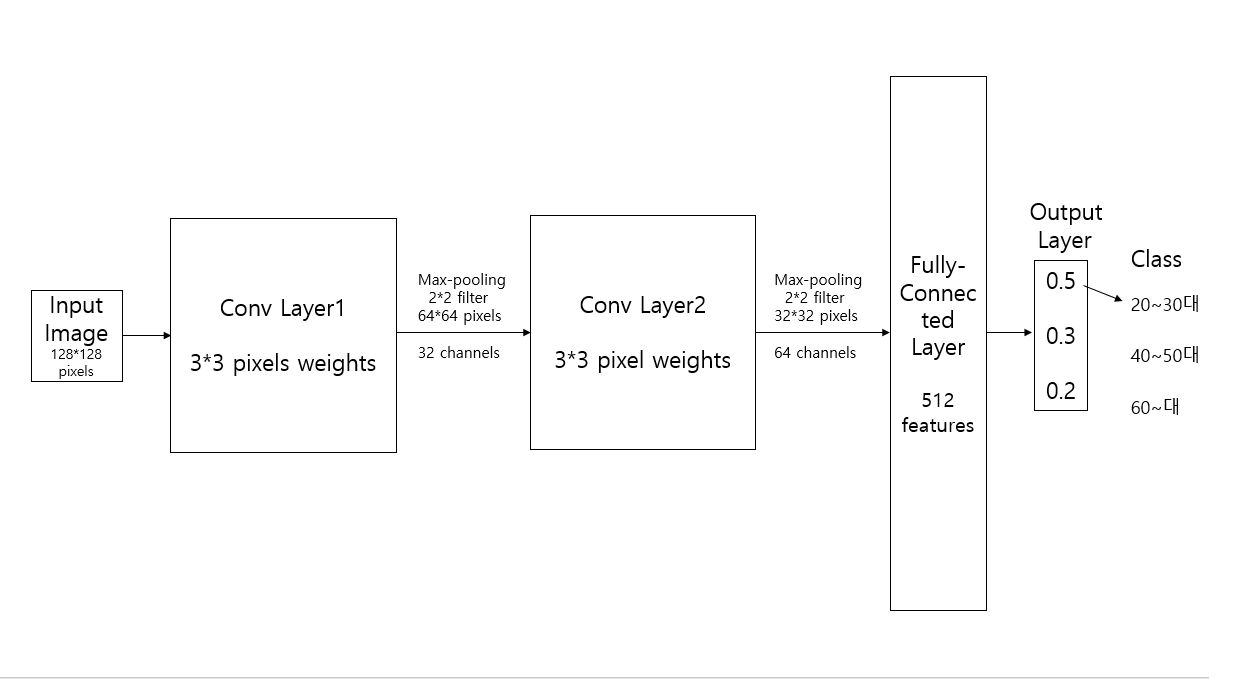

In [1]:
from IPython.display import Image
Image('./img/arflow.png')

# 아래는 이 모델에서 사용하는 계층구조.
# 아래의 계층구조를 가진 5개의 모델을 가지고 앙상블 적용
# 결과가 최다 표인것을 최종 앙상블모델의 결과로 사용

In [2]:
import tensorflow as tf
import numpy as np
import os
import sys
import datetime
from sklearn.model_selection import KFold, cross_val_score

In [3]:
# 변수선언
data_file_name = 'face_data_w.npz'
test_file_name = 'test_data_w.npz'

learning_rate = 0.000005
epochs = 6000
batch_size = 50
path = "./savedModel/a/"
num_models = 5

In [4]:
# 학습하는 모델 클래스
# 위의 이미지와 같은 계층구조를 가지고있음
class Model:
    def __init__(self, sess, name):
        self.name = name
        self._build_net()
        self.saver = tf.train.Saver()
        self.sess = sess
    
    def _build_net(self):
        with tf.variable_scope(self.name):
            self.training = tf.placeholder(tf.bool)
            
            # input place holders
            self.X = tf.placeholder(tf.float32, [None, 80, 55, 1])
            self.Y = tf.placeholder(tf.float32, [None, 3])
            
            # Convolution Layer 1 and Pooling Layer 1
            conv1 = tf.layers.conv2d(
                inputs = self.X,
                filters = 32,
                kernel_size = [3, 3],
                padding = 'SAME',
                activation = tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(
                inputs = conv1,
                pool_size = [2, 2],
                strides = 2,
                padding = 'SAME')
            dropout1 = tf.layers.dropout(
                inputs = pool1,
                rate = 0.7,
                training = self.training)
            
            # Convolution Layer 2 and Pooling Layer 2
            conv2 = tf.layers.conv2d(
                inputs = dropout1, 
                filters = 64,
                kernel_size = [3, 3],
                padding = 'SAME',
                activation = tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(
                inputs = conv2,
                pool_size = [2, 2],
                strides = 2,
                padding = 'SAME')
            dropout2 = tf.layers.dropout(
                inputs = pool2,
                rate = 0.7,
                training = self.training)
            
            # Dense Layer
            flat = tf.reshape(dropout2, [-1, 20 * 14 * 64])
            dense4 = tf.layers.dense(
                inputs = flat,
                units = 512,
                activation = tf.nn.relu)
            dropout4 = tf.layers.dropout(
                inputs = dense4,
                rate = 0.5,
                training = self.training)

            # Logits Layer (FC 1024 inputs -> 3 outputs)
            self.logits = tf.layers.dense(
                inputs = dropout4,
                units = 3)

        # Define cost, optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        correct_pred = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    def predict(self, x_test, training = False):
        return self.sess.run(
            self.logits,
            feed_dict = {self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training = False):
        return self.sess.run(
            self.acc,
            feed_dict = {self.X: x_test, self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training = True):
        return self.sess.run(
            [self.cost, self.optimizer],
            feed_dict = {self.X: x_data, self.Y: y_data, self.training: training})
    
    def save(self, path):
        self.saver.save(sess=self.sess, save_path=path+self.name)

    def load(self, path):
        self.saver.restore(self.sess, path+self.name)

In [5]:
# 사용할 데이터를 읽어오고 데이터를 나누어 줌
# 데이터는 5파트로 나누어 각 모델마다 한 파트를 validation set으로 나머지를 training set으로 사용

if os.path.isfile(data_file_name):
    file = np.load(data_file_name)
    data = file['data']
    labels = file['age_labels']
else:
    print("No data file.")
    sys.exit()
    
if os.path.isfile(test_file_name):
    file = np.load(test_file_name)
    td = file['data']
    tl = file['age_labels']
else:
    print("No test file")
    sys.exit()

idx = np.random.permutation(len(data))

data1 = data[idx, :]
labels1 = labels[idx, :]

x_tr = [0,0,0,0,0]
y_tr = [0,0,0,0,0]
x_va = [0,0,0,0,0]
y_va = [0,0,0,0,0]

kf = KFold(n_splits=5)
nn = 0
for tri, vai in kf.split(data):
    print(nn)
    x_tr[nn], x_va[nn] = data1[tri], data1[vai]
    y_tr[nn], y_va[nn] = labels1[tri], labels1[vai]
    nn += 1

print("data load success")

0
1
2
3
4
data load success


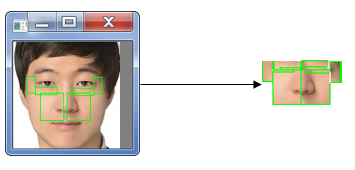

In [6]:
Image('./img/wrinkle.png')

# 사용한 데이터는 얼굴에서 위의 그림과 같이 주름 영역을 추출하여 그것을 조합해 사용함
# 아래 이미지는 사용한 데이터의 크기와 모양

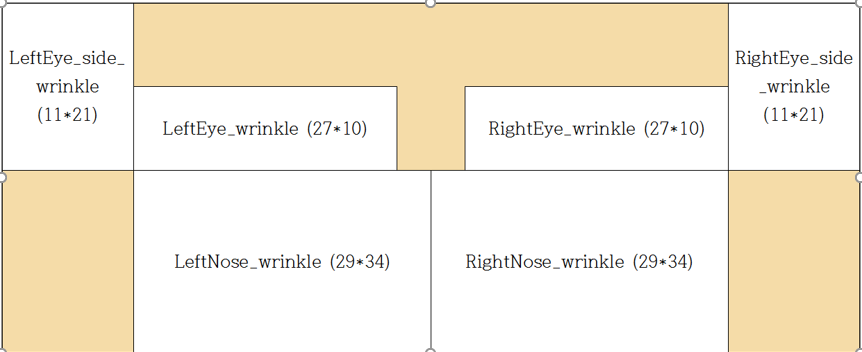

In [7]:
Image('./img/wrinkle2.png')

In [ ]:
# 저장 경로를 위한 함수
def get_path(num):
    dirt = path+str(num)+'/'
    if not os.path.exists(dirt):
        os.makedirs(dirt)
    return dirt

In [ ]:
sess = tf.Session()

# 5개의 모델을 생성
models = []
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

# train models
print('Learning started at ', datetime.datetime.now().time())

# 각 모델별로 학습을 시킴
for m_idx, m in enumerate(models):
    avg_cost_list = np.zeros(len(models))
    acc_list = np.zeros(len(models))
    
    print('Model ', '%1d' % (m_idx + 1))
    
    for epoch in range(epochs):
        avg_cost_list[m_idx] = 0
        total_batch = int(len(x_tr[m_idx]) / batch_size)
        training_batch = zip(range(0, len(x_tr[m_idx]), batch_size), range(batch_size, len(x_tr[m_idx]) + 1, batch_size))
        for start, end in training_batch:
            c, _ = m.train(x_tr[m_idx][start:end], y_tr[m_idx][start:end])
            avg_cost_list[m_idx] += c / total_batch
        acc_list[m_idx] = m.get_accuracy(x_va[m_idx], y_va[m_idx])    
        print('Model ', '%1d' % (m_idx + 1), 'epoch: ', '%04d' % (epoch + 1))
        print('cost = ', avg_cost_list[m_idx], '\naccuracy = ', acc_list[m_idx])
        print("   ")
    # 모델 저장
    save_path = get_path(m_idx)
    m.save(save_path)
    
print('Learning Finished at ', datetime.datetime.now().time())

Learning started at  21:38:00.133402
Model  1
Model  1 epoch:  0001
cost =  100.099449952 
accuracy =  0.709677398205
   
Model  1 epoch:  0002
cost =  87.947933356 
accuracy =  0.709677398205
   
Model  1 epoch:  0003
cost =  83.9185050329 
accuracy =  0.709677398205
   
Model  1 epoch:  0004
cost =  75.9493560791 
accuracy =  0.709677398205
   
Model  1 epoch:  0005
cost =  80.7526337306 
accuracy =  0.709677398205
   
Model  1 epoch:  0006
cost =  72.8549000422 
accuracy =  0.709677398205
   
Model  1 epoch:  0007
cost =  64.55874451 
accuracy =  0.709677398205
   
Model  1 epoch:  0008
cost =  64.9735725721 
accuracy =  0.709677398205
   
Model  1 epoch:  0009
cost =  62.1769147714 
accuracy =  0.709677398205
   
Model  1 epoch:  0010
cost =  63.0755937894 
accuracy =  0.709677398205
   
Model  1 epoch:  0011
cost =  62.3023885091 
accuracy =  0.709677398205
   
Model  1 epoch:  0012
cost =  58.5127275785 
accuracy =  0.709677398205
   
Model  1 epoch:  0013
cost =  59.0808883508 


In [ ]:
# test models and check accuracy
test_size = len(td)
predictions = np.zeros(test_size * 3).reshape(test_size, 3)

for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy: ', m.get_accuracy(td, tl))
    p = m.predict(td)
    predictions += p
    
ensemble_correct_prediction = tf.equal(
    tf.argmax(predictions, 1), tf.argmax(tl, 1))
ensemble_accuracy = (tf.reduce_mean(
    tf.cast(ensemble_correct_prediction, tf.float32)))
print('Ensemble accuracy: ', sess.run(ensemble_accuracy))

In [ ]:
# 불러오기를 넣어야함
